Instanciando la red pre-entrenada VGG16 y configurando la entrada para imágenes RGB 180x180

Sin expansión de datos y con la BD de perros y gatos reducida (sólo 5000 imágenes)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

Visualizando la arquitectura de la red

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Accediendo a la BD de perros y gatos



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
original_dir=r"/content/drive/MyDrive/PetImages"
new_base_dir=r"/content/drive/MyDrive/PetImages/cats_vs_dogs_small"

Mounted at /content/drive


Ajustando los datos de la BD de perros y gatos

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Extrayendo las características de los conjuntos de entrenamiento, validación y prueba con sus etiquetas

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
#test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 1s/step


In [ ]:
train_features.shape

(2000, 5, 5, 512)

Definiendo la arquitectura de la red e hiperparámetros de pérdida, algoritmo de descenso de gradiente y métrica de evaluación

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Entrenando ...

In [ ]:
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels))

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 17.9308 - accuracy: 0.9220 - val_loss: 7.5354 - val_accuracy: 0.9510
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 3.9812 - accuracy: 0.9740 - val_loss: 5.8313 - val_accuracy: 0.9620
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 1.5790 - accuracy: 0.9870 - val_loss: 4.7370 - val_accuracy: 0.9710
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1.6027 - accuracy: 0.9880 - val_loss: 7.5257 - val_accuracy: 0.9600
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.7568 - accuracy: 0.9920 - val_loss: 4.3958 - val_accuracy: 0.9710
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.2809 - accuracy: 0.9970 - val_loss: 5.3208 - val_accuracy: 0.9690
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.1028 - accuracy: 0.9990 - val_loss: 6.4369 - val_accuracy: 0.9670
Epoch 8/20
63/63 [=

Visualizando la pérdida y el accuracy durante el entrenamiento

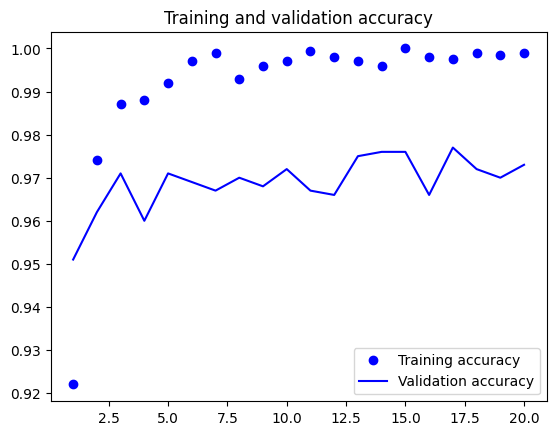

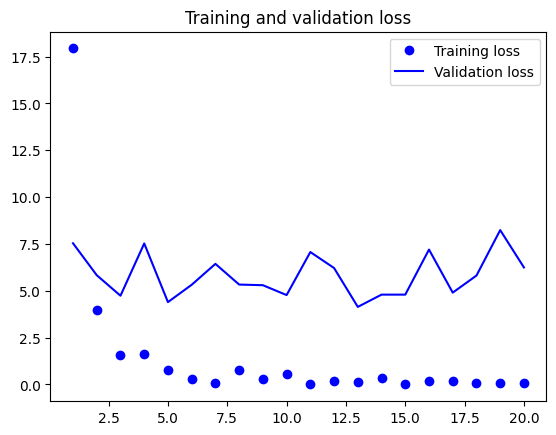

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Ejercicio:
---------
1. Si hay overfitting esta vez pruebe con regularización L1 y L2
2. Para mejorar los tiempos de ejecución intentar cambiando el batch-size